In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from nilearn import plotting
import glob


2025-09-14 07:21:17.473373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757834477.700678      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757834477.765284      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from pathlib import Path

root = Path("/kaggle/input/brats2023-part-1")

t1ce_list = sorted(glob.glob('/kaggle/input/brats2023-part-1/*/*t1c.nii'))
t2_flair_list = sorted(glob.glob('/kaggle/input/brats2023-part-1/*/*t2f.nii'))
t2w_list = sorted(glob.glob('/kaggle/input/brats2023-part-1/*/*t2w.nii'))
mask_list = sorted(glob.glob('/kaggle/input/brats2023-part-1/*/*seg.nii'))
 

print(len(t1ce_list), len(t2_flair_list), len(t2w_list), len(mask_list))



625 625 625 625


In [3]:
import os
import numpy as np
import nibabel as nib

# Create directories
for folder in ['train/images', 'train/masks', 'test/images', 'test/masks']:
    os.makedirs(f'/kaggle/working/{folder}', exist_ok=True)

# Limits based on available memory
MAX_SAMPLES = 625  # Adjust to fit within 18 GB memory
TEST_LIMIT = int(0.2 * MAX_SAMPLES)   # 20%
TRAIN_LIMIT = MAX_SAMPLES - TEST_LIMIT  # 80%

train_size, test_size, total = 0, 0, 0

print("Total MRI volumes available:", len(t2w_list))

def load_and_norm(path):
    """Load and min-max normalize an image volume to [0,1] in float32."""
    data = nib.load(path).get_fdata(dtype=np.float32)  # directly float32
    mn, mx = np.min(data), np.max(data)
    if mx > mn:  # avoid divide by zero
        data = (data - mn) / (mx - mn)
    return data

for img in range(len(t2w_list)):
    if total >= MAX_SAMPLES:
        break

    print("Preparing image:", img)
    try:
        # Load and normalize modalities
        temp_image_t2w   = load_and_norm(t2w_list[img])
        temp_image_t1ce  = load_and_norm(t1ce_list[img])
        temp_image_flair = load_and_norm(t2_flair_list[img])
        
        # Load segmentation mask as uint8 labels (lazy load → memory friendly)
        temp_mask = np.asarray(nib.load(mask_list[img]).dataobj, dtype=np.uint8)

    except Exception as e:
        print(f"Skipping image {img} due to loading error: {e}")
        continue

    # Crop (before stacking to save memory)
    temp_image_t2w   = temp_image_t2w[56:184, 56:184, 13:141]
    temp_image_t1ce  = temp_image_t1ce[56:184, 56:184, 13:141]
    temp_image_flair = temp_image_flair[56:184, 56:184, 13:141]
    temp_mask        = temp_mask[56:184, 56:184, 13:141]

    # Stack along channel axis → shape (128, 128, 128, 3)
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2w], axis=-1).astype(np.float32)

    # Free memory of individual modalities
    del temp_image_t2w, temp_image_t1ce, temp_image_flair

    # Skip empty masks (keep only if >1% non-background)
    val, counts = np.unique(temp_mask, return_counts=True)
    if (1 - (counts[0] / counts.sum())) > 0.01:
        if test_size < TEST_LIMIT:
            np.save(f'/kaggle/working/test/images/image_{img}.npy', temp_combined_images)
            np.save(f'/kaggle/working/test/masks/mask_{img}.npy', temp_mask.astype(np.uint8))
            test_size += 1
            print("Saved in Test folder")
        elif train_size < TRAIN_LIMIT:
            np.save(f'/kaggle/working/train/images/image_{img}.npy', temp_combined_images)
            np.save(f'/kaggle/working/train/masks/mask_{img}.npy', temp_mask.astype(np.uint8))
            train_size += 1
            print("Saved in Train folder")
        else:
            continue

        total += 1
        print(f"Shape: Image {temp_combined_images.shape}, Mask {temp_mask.shape}")
    else:
        print("Skipped: Empty/Non-informative mask")

    # Force garbage collection per loop iteration
    del temp_combined_images, temp_mask


Total MRI volumes available: 625
Preparing image: 0
Saved in Test folder
Shape: Image (128, 128, 128, 3), Mask (128, 128, 128)
Preparing image: 1
Saved in Test folder
Shape: Image (128, 128, 128, 3), Mask (128, 128, 128)
Preparing image: 2
Saved in Test folder
Shape: Image (128, 128, 128, 3), Mask (128, 128, 128)
Preparing image: 3
Saved in Test folder
Shape: Image (128, 128, 128, 3), Mask (128, 128, 128)
Preparing image: 4
Saved in Test folder
Shape: Image (128, 128, 128, 3), Mask (128, 128, 128)
Preparing image: 5
Skipped: Empty/Non-informative mask
Preparing image: 6
Skipped: Empty/Non-informative mask
Preparing image: 7
Skipped: Empty/Non-informative mask
Preparing image: 8
Saved in Test folder
Shape: Image (128, 128, 128, 3), Mask (128, 128, 128)
Preparing image: 9
Saved in Test folder
Shape: Image (128, 128, 128, 3), Mask (128, 128, 128)
Preparing image: 10
Saved in Test folder
Shape: Image (128, 128, 128, 3), Mask (128, 128, 128)
Preparing image: 11
Saved in Test folder
Shape: I

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
import random

class BrainTumorDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=2, num_classes=4, 
                 shuffle=True, one_hot=True, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.one_hot = one_hot
        self.augment_flag = augment
        self.indexes = np.arange(len(self.image_files))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        # Get batch indices
        batch_idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_images, batch_masks = [], []

        for i in batch_idx:
            img = np.load(os.path.join(self.image_dir, self.image_files[i])).astype(np.float32)
            mask = np.load(os.path.join(self.mask_dir, self.mask_files[i])).astype(np.uint8)

            # Convert mask to one-hot if required
            if self.one_hot:
                mask = to_categorical(mask, num_classes=self.num_classes).astype(np.float32)

            # ✅ Apply augmentations
            if self.augment_flag:
                img, mask = self.augment(img, mask)

            batch_images.append(img)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def augment(self, img, mask):
        """Apply random augmentations to image and mask together"""

        # --- Random Flip ---
        if random.random() > 0.5:
            img = np.flip(img, axis=0)
            mask = np.flip(mask, axis=0)
        if random.random() > 0.5:
            img = np.flip(img, axis=1)
            mask = np.flip(mask, axis=1)
        if random.random() > 0.5:
            img = np.flip(img, axis=2)
            mask = np.flip(mask, axis=2)

        # --- Random Rotation (90° steps) ---
        k = random.choice([0,1,2,3])  # rotate by 0,90,180,270
        img = np.rot90(img, k, axes=(0,1))
        mask = np.rot90(mask, k, axes=(0,1))

        # --- Random Intensity Scaling ---
        if random.random() > 0.5:
            scale = 1.0 + random.uniform(-0.1, 0.1)  # ±10%
            img = img * scale

        # --- Random Gaussian Noise ---
        if random.random() > 0.5:
            noise = np.random.normal(0, 0.01, img.shape)
            img = img + noise

        # Clip to safe range
        img = np.clip(img, 0, 1.0)

        return img, mask


In [52]:


train_gen = BrainTumorDataGenerator(
    image_dir="/kaggle/working/train/images",
    mask_dir="/kaggle/working/train/masks",
    batch_size=2,
    num_classes=4,
    shuffle=True,
    one_hot=True,
    augment=True   # enable augmentations
)

test_gen = BrainTumorDataGenerator(
    image_dir="/kaggle/working/test/images",
    mask_dir="/kaggle/working/test/masks",
    batch_size=2,
    num_classes=4,
    shuffle=False,
    one_hot=True,
    augment=False  # no augmentation for validation
)


# Example usage
x, y = train_gen[0]
print("Image batch:", x.shape)  # (B, 128, 128, 128, 3)
print("Mask batch:", y.shape)   # (B, 128, 128, 128, 4) since one_hot=True


Image batch: (2, 128, 128, 128, 3)
Mask batch: (2, 128, 128, 128, 4)


In [80]:
"""
UNeXt3D - lightweight 3D U-Net inspired by UNeXt (TensorFlow / Keras)

- Depthwise 3D conv implemented via Conv3D(groups=in_channels)
- Channel-MLP via 1x1x1 Conv3D
- Residual U-Net encoder-decoder with skip connections
- Channels-last (NDHWC)

Tested with TF 2.8+ (groups in Conv3D supported in TF 2.4+; if your TF lacks groups support,
use a grouped-conv fallback which I can provide).
"""

import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# ---------------------------
# Small helpers
# ---------------------------

def DepthwiseConv3D(in_channels, kernel_size=3, padding='same', strides=1, name=None):
    """
    Depthwise-like Conv3D: implemented as Conv3D with groups=in_channels.
    Requires TF/Keras Conv3D to support `groups` argument.
    """
    return layers.Conv3D(
        filters=in_channels,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        groups=in_channels,
        use_bias=False,
        kernel_initializer="he_normal",
        name=name
    )


def PointwiseConv3D(out_channels, name=None):
    """1x1x1 Conv for channel mixing"""
    return layers.Conv3D(
        filters=out_channels,
        kernel_size=1,
        padding='same',
        use_bias=True,
        kernel_initializer="he_normal",
        name=name
    )


def ChannelMLP3D(channels, expansion=2.0, act=tf.nn.gelu, name=None):
    """Small per-location channel MLP implemented with 1x1x1 convs"""
    hidden = max(4, int(channels * expansion))
    seq = tf.keras.Sequential(name=name)
    seq.add(PointwiseConv3D(hidden, name=None if name is None else f"{name}_mlp1"))
    seq.add(layers.Activation(act, name=None if name is None else f"{name}_mlp1_act"))
    seq.add(PointwiseConv3D(channels, name=None if name is None else f"{name}_mlp2"))
    return seq


In [81]:
import tensorflow as tf
from tensorflow.keras import layers

class UNeXtBlock3D(layers.Layer):
    def __init__(self, channels, expansion=2.0, drop=0.0, use_bn=True, act='gelu', **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.expansion = expansion
        self.drop = float(drop)
        self.use_bn = use_bn
        self.act_name = act

        # Layers (create here but don't call build on children — Keras will build them)
        self.conv1 = layers.Conv3D(int(channels * expansion), kernel_size=1, padding='same', use_bias=not use_bn)
        self.bn1 = layers.BatchNormalization() if use_bn else None
        self.act = (tf.nn.gelu if act == 'gelu' else (tf.nn.swish if act=='swish' else tf.nn.relu))
        self.conv2 = layers.Conv3D(channels, kernel_size=1, padding='same', use_bias=not use_bn)
        self.bn2 = layers.BatchNormalization() if use_bn else None
        self.dropout = layers.Dropout(self.drop) if self.drop > 0 else None

        # small MLP for residual path (example)
        self.mlp = tf.keras.Sequential([
            layers.Conv3D(channels, 1, padding='same'),
            layers.BatchNormalization() if use_bn else layers.Lambda(lambda x: x),
            layers.Activation(self.act)
        ])

    def call(self, inputs, training=None):
        x = inputs
        # expansion conv
        x = self.conv1(x)
        if self.bn1 is not None:
            x = self.bn1(x, training=training)
        x = self.act(x)

        # optionally dropout
        if self.dropout is not None:
            x = self.dropout(x, training=training)

        # project back
        x = self.conv2(x)
        if self.bn2 is not None:
            x = self.bn2(x, training=training)

        # residual + small mlp
        res = self.mlp(inputs, training=training) if hasattr(self.mlp, "call") else self.mlp(inputs)
        out = tf.keras.layers.add([inputs, x, res])
        out = self.act(out)
        return out

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "channels": self.channels,
            "expansion": self.expansion,
            "drop": self.drop,
            "use_bn": self.use_bn,
            "act": self.act_name
        })
        return cfg


In [82]:
#2
class Up3D(layers.Layer):
    def __init__(self, out_ch, blocks=1, expansion=2.0, drop=0.0,
                 use_bn=True, act=tf.nn.gelu, name=None):
        super().__init__(name=name)
        self.out_ch = out_ch
        self.up = layers.Conv3DTranspose(
            out_ch, kernel_size=2, strides=2, padding='same',
            name=None if name is None else f"{name}_up"
        )
        self.blocks = [UNeXtBlock3D(out_ch, expansion=expansion, drop=drop,
                                    use_bn=use_bn, act=act,
                                    name=None if name is None else f"{name}_block{i}")
                       for i in range(blocks)]
        self._skip_proj = None   # will be built lazily
        self._reduce = None      # projection after concat

    def build(self, input_shape):
        # input_shape here is for x (upsampled input), we can't know skip yet
        self._reduce = PointwiseConv3D(self.out_ch, name=self.name + "_reduce")
        super().build(input_shape)

    def call(self, x, skip, training=None):
        x = self.up(x)  # upsample

        # lazily create skip projection if needed
        if self._skip_proj is None and skip.shape[-1] != self.out_ch:
            self._skip_proj = PointwiseConv3D(self.out_ch, name=self.name + "_skip_proj")

        if self._skip_proj is not None:
            skip = self._skip_proj(skip)

        # concat and reduce
        x = layers.Concatenate(axis=-1)([x, skip])
        x = self._reduce(x)

        for b in self.blocks:
            x = b(x, training=training)
        return x


In [83]:
#2
class Down3D(layers.Layer):
    def __init__(self, out_ch, blocks=1, expansion=2.0, drop=0.0,
                 use_bn=True, act=tf.nn.gelu, name=None):
        super().__init__(name=name)
        self.out_ch = out_ch
        self.blocks = [UNeXtBlock3D(out_ch, expansion=expansion, drop=drop,
                                    use_bn=use_bn, act=act,
                                    name=None if name is None else f"{name}_block{i}")
                       for i in range(blocks)]
        self.pool = layers.MaxPool3D(pool_size=(2,2,2))
        self._proj = None

    def build(self, input_shape):
        C_in = input_shape[-1]
        if C_in is not None and C_in != self.out_ch:
            self._proj = PointwiseConv3D(self.out_ch, name=self.name + "_proj")
        super().build(input_shape)

    def call(self, x, training=None):
        if self._proj is not None:
            x = self._proj(x)
        for b in self.blocks:
            x = b(x, training=training)
        skip = x
        x = self.pool(x)
        return skip, x


In [79]:

# Replace your existing Down3D / Up3D with these fixed versions

class Down3D(layers.Layer):
    def __init__(self, out_ch, blocks=1, expansion=2.0, drop=0.0, use_bn=True, act=tf.nn.gelu, name=None):
        super().__init__(name=name)
        self.out_ch = out_ch
        self.blocks = [UNeXtBlock3D(out_ch, expansion=expansion, drop=drop, use_bn=use_bn, act=act,
                                    name=None if name is None else f"{name}_block{i}")
                       for i in range(blocks)]
        self.pool = layers.MaxPool3D(pool_size=(2,2,2))
        # a small pointwise projector to ensure channel compatibility
        self._proj = None  # will be lazily created if needed

    def build(self, input_shape):
        # input_shape: (B, D, H, W, C_in) -> C_in may be None; build lazy proj only if known
        C_in = input_shape[-1]
        if C_in is not None and C_in != self.out_ch:
            self._proj = PointwiseConv3D(self.out_ch, name=(self.name + "_proj") if self.name else None)
        super().build(input_shape)

    def call(self, x, training=None):
        # Ensure correct channels before applying blocks
        Cin = tf.shape(x)[-1]  # dynamic
        # If _proj exists (static known in build), use it. Otherwise create on-the-fly (safe) 
        if self._proj is not None:
            x = self._proj(x)
        else:
            # If shape is fully known at runtime and mismatches, create projector
            if x.shape[-1] is not None and x.shape[-1] != self.out_ch:
                x = PointwiseConv3D(self.out_ch)(x)

        # Apply the blocks
        for b in self.blocks:
            x = b(x, training=training)
        skip = x
        x = self.pool(x)
        return skip, x


class Up3D(layers.Layer):
    def __init__(self, out_ch, blocks=1, expansion=2.0, drop=0.0, use_bn=True, act=tf.nn.gelu, name=None):
        super().__init__(name=name)
        self.up = layers.Conv3DTranspose(out_ch, kernel_size=2, strides=2, padding='same', name=None if name is None else f"{name}_up")
        self.out_ch = out_ch
        self.blocks = [UNeXtBlock3D(out_ch, expansion=expansion, drop=drop, use_bn=use_bn, act=act,
                                    name=None if name is None else f"{name}_block{i}")
                       for i in range(blocks)]
        self._skip_proj = None  # to ensure skip channels match if needed

    def build(self, input_shape):
        # input_shape for Up3D.call will be (x_shape, skip_shape) in symbolic graph; we only get x_shape here,
        # so we lazily handle skip projection in call if needed.
        super().build(input_shape)

    def call(self, x, skip, training=None):
        x = self.up(x)  # upsampled
        # After upsampling, channels of x should be out_ch
        # Ensure skip has channels == out_ch, otherwise project skip
        if skip.shape[-1] is None:
            # dynamic: if unknown, we'll try to project at runtime if needed
            if tf.shape(skip)[-1] != self.out_ch:
                skip = PointwiseConv3D(self.out_ch)(skip)
        else:
            if skip.shape[-1] != self.out_ch:
                skip = PointwiseConv3D(self.out_ch)(skip)

        # concat then apply blocks
        x = layers.Concatenate(axis=-1)([x, skip])
        # Note: concatenation doubles channels; blocks are created expecting out_ch,
        # so ensure your UNeXtBlock3D handles the concatenated channel count or
        # you may want to follow concat with a PointwiseConv3D to reduce to out_ch:
        # reduce = PointwiseConv3D(self.out_ch)(x)
        # and then pass `reduce` into blocks. This is safer.
        # I'll implement that here:
        x = PointwiseConv3D(self.out_ch)(x)

        for b in self.blocks:
            x = b(x, training=training)
        return x


In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming PointwiseConv3D, UNeXtBlock3D, Down3D, Up3D are already defined

import tensorflow as tf
from tensorflow.keras import layers, models

def build_unext3d(
    input_shape=(128,128,128,3),
    num_classes=4,
    base_filters=16,
    depth=4,
    blocks_per_stage=1,
    drop=0.0,
    act=tf.nn.gelu,
    use_bn=True,
    bilinear=False
):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    skips = []
    filters = base_filters

    # ---------------- Encoder ---------------- #
    for d in range(depth):
        down = Down3D(
            out_ch=filters,
            blocks=blocks_per_stage,
            expansion=2.0,
            drop=drop,
            use_bn=use_bn,
            act=act,
            name=f"down{d}"
        )
        skip, x = down(x)
        skips.append(skip)
        filters *= 2  # prepare for next stage

    # ---------------- Bottleneck ---------------- #
    # correct filters back (we multiplied once too many in the loop)
    filters //= 2
    x = UNeXtBlock3D(filters, expansion=2.0, drop=drop,
                     use_bn=use_bn, act=act, name="bottleneck_block")(x)

    # ---------------- Decoder ---------------- #
    for d in reversed(range(depth)):
        up = Up3D(
            out_ch=filters,
            blocks=blocks_per_stage,
            expansion=2.0,
            drop=drop,
            use_bn=use_bn,
            act=act,
            name=f"up{d}"
        )
        x = up(x, skips[d])
        filters //= 2  # halve channels as we move up

    # ---------------- Output Layer ---------------- #
    outputs = layers.Conv3D(num_classes, kernel_size=1, activation="softmax")(x)

    return models.Model(inputs, outputs, name="UNeXt3D")



In [85]:
# Build model (use the defaults from your signature)
model = build_unext3d(
    input_shape=(128,128,128,3),
    num_classes=4,
    base_filters=16,
    depth=4,
    blocks_per_stage=1,
    drop=0.0,
    act=tf.nn.gelu,   # or pass the function object you used originally
    use_bn=True,
    bilinear=True
)

# Sanity check: print model summary
print("Model built — layers / params:")
model.summary()


Model built — layers / params:


Model: "UNeXt3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_84      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down0 (Down3D)      │ [(None, 128, 128, │      1,616 │ input_layer_84[0… │
│                     │ 128, 16), (None,  │            │                   │
│                     │ 64, 64, 64, 16)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1 (Down3D)      │ [(None, 64, 64,   │      6,208 │ down0[0][1]       │
│                     │ 64, 32), (None,   │            │                   │
│                     │ 32, 32, 32, 32)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down2 (Down3D)      │ [(None, 32, 32,   │     23,680 │ down1[0][1]       │
│                     │ 32, 64), (None,   │            │                   │
│                     │ 16, 16, 16, 64)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down3 (Down3D)      │ [(None, 16, 16,   │     92,416 │ down2[0][1]       │
│                     │ 16, 128), (None,  │            │                   │
│                     │ 8, 8, 8, 128)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_block    │ (None, 8, 8, 8,   │     84,096 │ down3[0][1]       │
│ (UNeXtBlock3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up3 (Up3D)          │ (None, 16, 16,    │    248,192 │ bottleneck_block… │
│                     │ 16, 128)          │            │ down3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up2 (Up3D)          │ (None, 32, 32,    │     95,424 │ up3[0][0],        │
│                     │ 32, 64)           │            │ down2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up1 (Up3D)          │ (None, 64, 64,    │     24,160 │ up2[0][0],        │
│                     │ 64, 32)           │            │ down1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up0 (Up3D)          │ (None, 128, 128,  │      6,192 │ up1[0][0],        │
│                     │ 128, 16)          │            │ down0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_277 (Conv3D) │ (None, 128, 128,  │         68 │ up0[0][0]         │
│                     │ 128, 4)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 582,052 (2.22 MB)

 Trainable params: 577,188 (2.20 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [86]:
import inspect
print(inspect.signature(build_unext3d))


(input_shape=(128, 128, 128, 3), num_classes=4, base_filters=16, depth=4, blocks_per_stage=1, drop=0.0, act=<function gelu at 0x7a3acafec860>, use_bn=True, bilinear=False)


In [87]:
model = build_unext3d(
    input_shape=(128,128,128,3),  # input volume shape
    num_classes=4,                # number of segmentation classes
    base_filters=16,              # starting filters
    depth=4,                      # encoder depth
    blocks_per_stage=2,           # blocks per stage (optional)
    drop=0.1                      # dropout rate (optional)
)
model.summary()

Model: "UNeXt3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_94      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down0 (Down3D)      │ [(None, 128, 128, │      3,168 │ input_layer_94[0… │
│                     │ 128, 16), (None,  │            │                   │
│                     │ 64, 64, 64, 16)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1 (Down3D)      │ [(None, 64, 64,   │     11,872 │ down0[0][1]       │
│                     │ 64, 32), (None,   │            │                   │
│                     │ 32, 32, 32, 32)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down2 (Down3D)      │ [(None, 32, 32,   │     45,248 │ down1[0][1]       │
│                     │ 32, 64), (None,   │            │                   │
│                     │ 16, 16, 16, 64)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down3 (Down3D)      │ [(None, 16, 16,   │    176,512 │ down2[0][1]       │
│                     │ 16, 128), (None,  │            │                   │
│                     │ 8, 8, 8, 128)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_block    │ (None, 8, 8, 8,   │     84,096 │ down3[0][1]       │
│ (UNeXtBlock3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up3 (Up3D)          │ (None, 16, 16,    │    332,288 │ bottleneck_block… │
│                     │ 16, 128)          │            │ down3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up2 (Up3D)          │ (None, 32, 32,    │    116,992 │ up3[0][0],        │
│                     │ 32, 64)           │            │ down2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up1 (Up3D)          │ (None, 64, 64,    │     29,824 │ up2[0][0],        │
│                     │ 64, 32)           │            │ down1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up0 (Up3D)          │ (None, 128, 128,  │      7,744 │ up1[0][0],        │
│                     │ 128, 16)          │            │ down0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_329 (Conv3D) │ (None, 128, 128,  │         68 │ up0[0][0]         │
│                     │ 128, 4)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 807,812 (3.08 MB)

 Trainable params: 799,108 (3.05 MB)

 Non-trainable params: 8,704 (34.00 KB)

In [88]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import MeanIoU

# Dice Coefficient (as metric)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss function (used in total_loss)
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined loss: Dice + Cross Entropy
cross_entropy = CategoricalCrossentropy()
def total_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + cross_entropy(y_true, y_pred)

# Optimizer
optim = Adam(learning_rate=1e-4)



In [89]:
# Compile model
with tf.device('/gpu:0'):
    model.compile(
        optimizer=optim,
        loss=total_loss,
        metrics=[
            'accuracy',
            dice_coef,
            tf.keras.metrics.MeanIoU(num_classes=4)
        ]
    )

# Summary
print(model.summary())


Model: "UNeXt3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_94      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down0 (Down3D)      │ [(None, 128, 128, │      3,168 │ input_layer_94[0… │
│                     │ 128, 16), (None,  │            │                   │
│                     │ 64, 64, 64, 16)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1 (Down3D)      │ [(None, 64, 64,   │     11,872 │ down0[0][1]       │
│                     │ 64, 32), (None,   │            │                   │
│                     │ 32, 32, 32, 32)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down2 (Down3D)      │ [(None, 32, 32,   │     45,248 │ down1[0][1]       │
│                     │ 32, 64), (None,   │            │                   │
│                     │ 16, 16, 16, 64)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down3 (Down3D)      │ [(None, 16, 16,   │    176,512 │ down2[0][1]       │
│                     │ 16, 128), (None,  │            │                   │
│                     │ 8, 8, 8, 128)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_block    │ (None, 8, 8, 8,   │     84,096 │ down3[0][1]       │
│ (UNeXtBlock3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up3 (Up3D)          │ (None, 16, 16,    │    332,288 │ bottleneck_block… │
│                     │ 16, 128)          │            │ down3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up2 (Up3D)          │ (None, 32, 32,    │    116,992 │ up3[0][0],        │
│                     │ 32, 64)           │            │ down2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up1 (Up3D)          │ (None, 64, 64,    │     29,824 │ up2[0][0],        │
│                     │ 64, 32)           │            │ down1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up0 (Up3D)          │ (None, 128, 128,  │      7,744 │ up1[0][0],        │
│                     │ 128, 16)          │            │ down0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_329 (Conv3D) │ (None, 128, 128,  │         68 │ up0[0][0]         │
│                     │ 128, 4)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 807,812 (3.08 MB)

 Trainable params: 799,108 (3.05 MB)

 Non-trainable params: 8,704 (34.00 KB)

None


In [90]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',        # You can also monitor 'val_accuracy' or other metrics
    patience=5,                # Stop after 5 epochs with no improvement
    restore_best_weights=True, # Restore the best weights after stopping
    verbose=1
)

In [91]:
history = model.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=10,
    verbose=1,
    validation_data=test_gen,
    validation_steps=10,
    callbacks=[early_stop]
)


Epoch 1/10


I0000 00:00:1757841429.212553      99 service.cc:148] XLA service 0x7a39f821ff30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757841429.213645      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757841434.159260      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1757841438.372357      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757841438.562333      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757841439.214479      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757841439.4141

30/30 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.6320 - dice_coef: 0.5284 - loss: 1.7254 - mean_io_u_1: 0.3751 - val_accuracy: 0.6774 - val_dice_coef: 0.4209 - val_loss: 1.6442 - val_mean_io_u_1: 0.3750
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8870 - dice_coef: 0.7380 - loss: 0.9671 - mean_io_u_1: 0.3751 - val_accuracy: 0.9334 - val_dice_coef: 0.6150 - val_loss: 0.9991 - val_mean_io_u_1: 0.3750
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 961ms/step - accuracy: 0.9516 - dice_coef: 0.9010 - loss: 0.4734 - mean_io_u_1: 0.3754 - val_accuracy: 0.9476 - val_dice_coef: 0.7569 - val_loss: 0.6449 - val_mean_io_u_1: 0.3750
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 988ms/step - accuracy: 0.9510 - dice_coef: 0.9270 - loss: 0.3953 - mean_io_u_1: 0.3756 - val_accuracy: 0.9482 - val_dice_coef: 0.8454 - val_loss: 0.4492 - val_mean_io_u_1: 0.3750
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 926ms/step - accuracy: 0.9581 - dice_coef: 0.9408 - loss: 0.2818 - mean_io_u_1: 0.3755 - v

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step - accuracy: 0.9625 - dice_coef: 0.9501 - loss: 0.2052 - mean_io_u_1: 0.3766 - val_accuracy: 0.9514 - val_dice_coef: 0.9387 - val_loss: 0.2813 - val_mean_io_u_1: 0.3750
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9517 - dice_coef: 0.9387 - loss: 0.2471 - mean_io_u_1: 0.3766 - val_accuracy: 0.9522 - val_dice_coef: 0.9449 - val_loss: 0.2856 - val_mean_io_u_1: 0.3750
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 890ms/step - accuracy: 0.9571 - dice_coef: 0.9434 - loss: 0.2237 - mean_io_u_1: 0.3763 - val_accuracy: 0.9538 - val_dice_coef: 0.9491 - val_loss: 0.2822 - val_mean_io_u_1: 0.3750
Restoring model weights from the end of the best epoch: 8.


In [92]:
model.save('/kaggle/working/3DUnext.hdf5')

NotImplementedError: 
Object Down3D was created by passing
non-serializable argument values in `__init__()`,
and therefore the object must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [93]:
import pandas as pd

def generate_final_report(history):
    last_epoch = len(history.history['loss']) - 1
    metrics_report = {k: round(history.history[k][last_epoch], 4) for k in history.history}
    df = pd.DataFrame(metrics_report, index=['Final'])
    return df.T  # transpose for readability

# Generate and display report
final_report = generate_final_report(history)
print(final_report)


                  Final
accuracy         0.9606
dice_coef        0.9470
loss             0.2034
mean_io_u_1      0.3766
val_accuracy     0.9538
val_dice_coef    0.9491
val_loss         0.2822
val_mean_io_u_1  0.3750


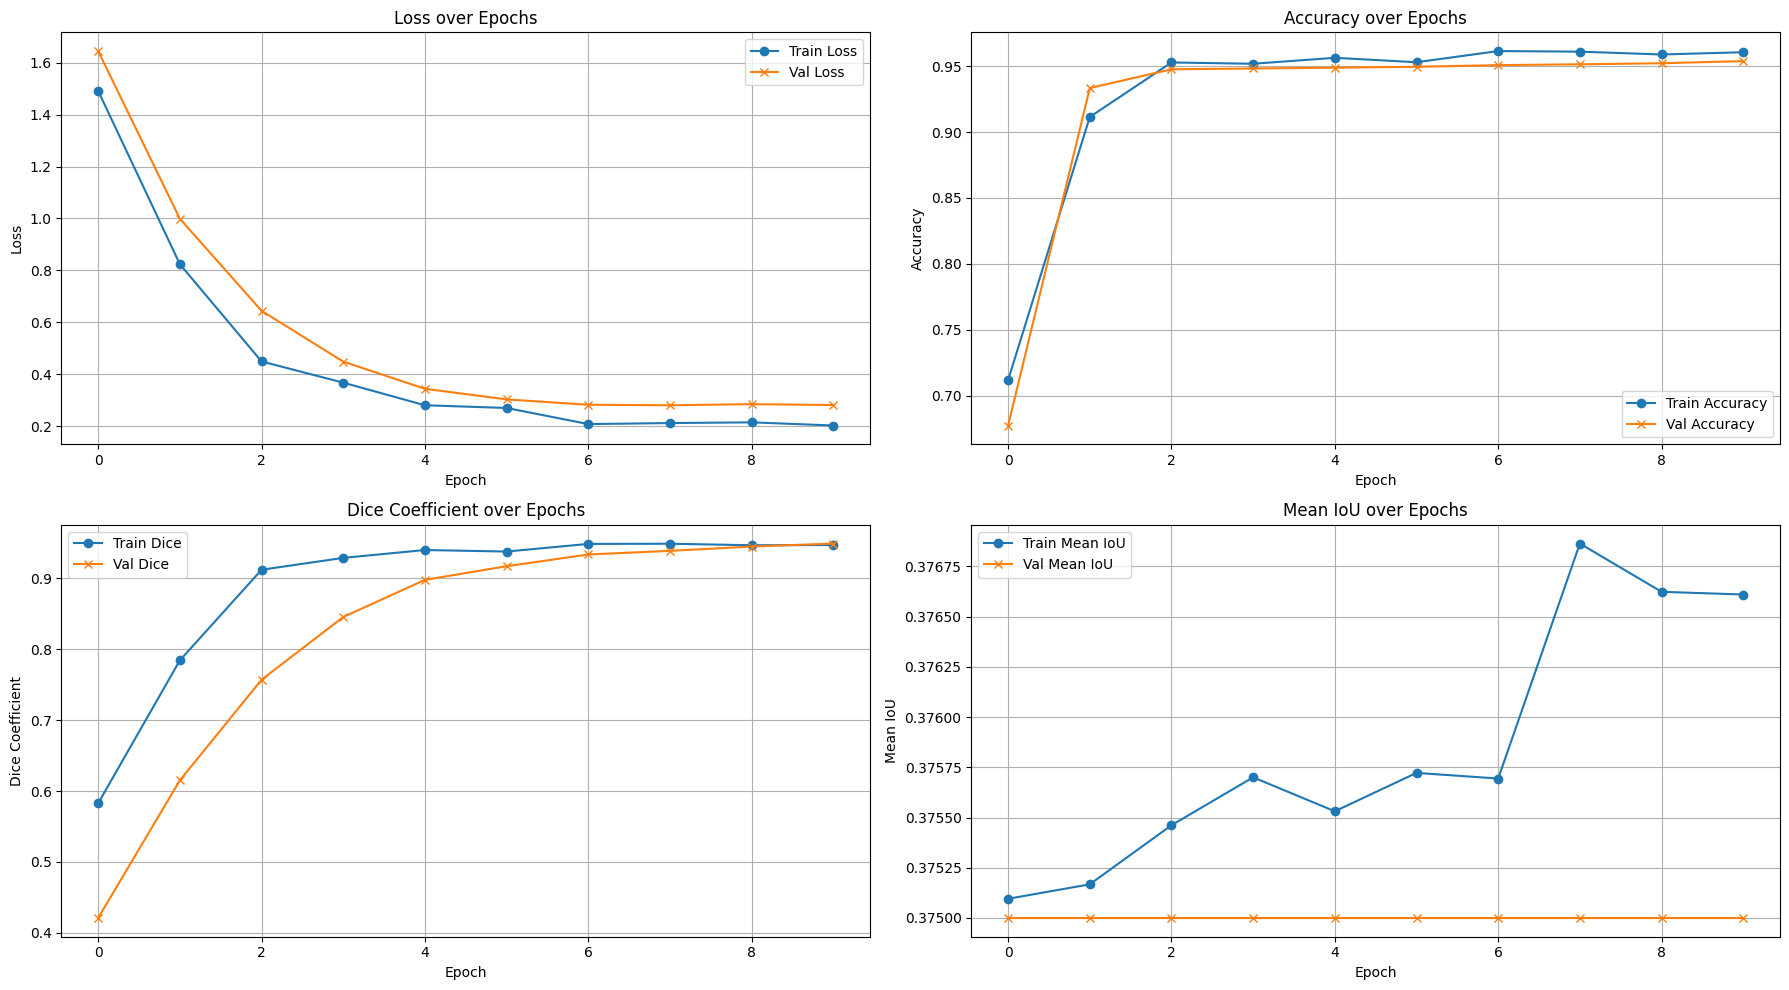

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# 1. Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 3. Plot Dice Coefficient
plt.subplot(2, 2, 3)
plt.plot(history.history['dice_coef'], label='Train Dice', marker='o')
plt.plot(history.history['val_dice_coef'], label='Val Dice', marker='x')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)

# 4. Plot Mean IoU
plt.subplot(2, 2, 4)
plt.plot(history.history['mean_io_u_1'], label='Train Mean IoU', marker='o')
plt.plot(history.history['val_mean_io_u_1'], label='Val Mean IoU', marker='x')
plt.title('Mean IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
